### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import geopy

### Imports Dataset

In [2]:
airbnbData = pd.read_csv('./Data/Airbnb_Open_Data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Analyzing Data

### Checking dataset essentials

In [3]:
print("Shape: ", airbnbData.shape, "\n")

print("Columns: ", airbnbData.columns, "\n\n")

# Dropping columns that won't be usuful to model or has data leakage
droppingColumns = [
    'id', 'NAME', 'host id', 'host name', 'last review',
    'calculated host listings count', 'house_rules', 'license', 'availability 365',
    'country', 'country code']

airbnbData.drop(droppingColumns, axis =1 , inplace=True)

print("Null count before dropping:\n ",airbnbData.isnull().sum(), "\n\n")

# Drops all rows with a null value since the dataset is large
airbnbData = airbnbData.loc[airbnbData.isnull().sum(axis=1) == 0,:]
print("Shape after dropping:\n ", airbnbData.shape)
print("Null count after droping:\n ", airbnbData.isnull().sum())

airbnbData

Shape:  (102599, 26) 

Columns:  Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object') 


Null count before dropping:
  host_identity_verified      289
neighbourhood group          29
neighbourhood                16
lat                           8
long                          8
instant_bookable            105
cancellation_policy          76
room type                     0
Construction year           214
price                       247
service fee                 273
minimum nights              409
number of reviews           183
reviews per month     

,host_identity_verified,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,9.0,0.21,4.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,0.38,4.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,4.64,4.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,0.10,3.0
5,verified,Manhattan,Murray Hill,40.74767,-73.97500,True,flexible,Entire home/apt,2013.0,$577,$115,3.0,74.0,0.59,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102588,unconfirmed,Manhattan,Flatiron District,40.74068,-73.98999,True,flexible,Entire home/apt,2016.0,$618,$124,1.0,177.0,3.78,4.0
102591,verified,Manhattan,Upper West Side,40.77408,-73.98181,False,strict,Entire home/apt,2005.0,"$1,139",$228,5.0,17.0,0.35,5.0
102593,verified,Manhattan,East Village,40.72826,-73.98422,True,strict,Private room,2017.0,"$1,099",$220,1.0,8.0,0.16,4.0
102595,unconfirmed,Manhattan,Morningside Heights,40.80460,-73.96545,True,moderate,Private room,2016.0,$837,$167,1.0,1.0,0.02,2.0


### Removing all none well rated posts

In [4]:
# Must have more than 4 star rating
# Must have more than 1 review per month
# Must have more than 20 reviews

print("Reviews per month mean: " ,airbnbData['reviews per month'].mean())
print("Number of reviews mean: " ,airbnbData['number of reviews'].mean())
print("Reviews rate mean: " , airbnbData['review rate number'].mean())

print("\nOriginal Shape: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['review rate number'] >= 4,:]

print("After a low score remvoving: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['number of reviews'] >= 10,:]

print("After removing number of reviews: " , airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['reviews per month'] >= 0.5,:]

print("After removing low monthly review rate dropping: " , airbnbData.shape)


#Reset the index

airbnbData.reset_index(inplace=True, drop=True)



Reviews per month mean:  1.3747339425832923
Number of reviews mean:  32.26613964196777
Reviews rate mean:  3.2802236526805433

Original Shape:  (85132, 15)
After a low score remvoving:  (38827, 15)
After removing number of reviews:  (20481, 15)
After removing low monthly review rate dropping:  (17700, 15)


### Converts string dollars to floats

In [5]:
dollarsColumns = ['price', 'service fee']

# Uses Regex to remove all none numeric characters
# Then converts the column to numeric values
for dolCol in dollarsColumns:  
    airbnbData[dolCol] = airbnbData[dolCol].apply(lambda x: re.sub(r'\D', '',x))
    airbnbData[dolCol] = pd.to_numeric(airbnbData[dolCol])

airbnbData[dollarsColumns]

,price,service fee
0,368,74
1,291,58
2,714,143
3,580,116
4,439,88
...,...,...
17695,605,121
17696,985,197
17697,294,59
17698,77,15


## Visualizing Data

In [6]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'gray'})

### Visualizing Price

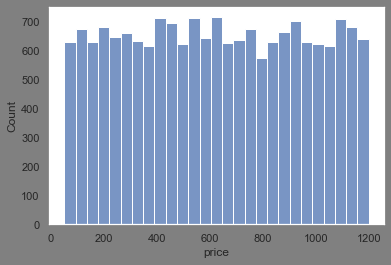

In [7]:
sns.histplot(data = airbnbData, x='price')

plt.show()

### Visualizing Room Type

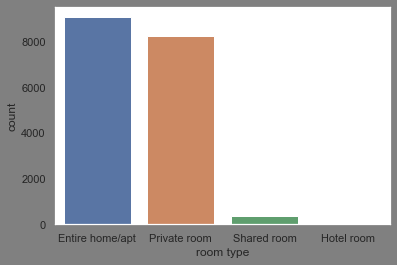

In [8]:
sns.countplot(data = airbnbData, x='room type')

plt.show()

### Visualizing Instant Bookable

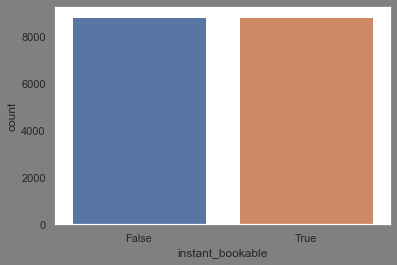

In [9]:
sns.countplot(data = airbnbData, x='instant_bookable')

plt.show()

### Visualizing Cancelation Policy

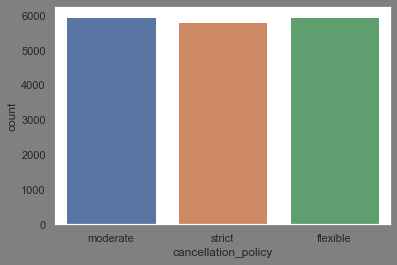

In [10]:
sns.countplot(data = airbnbData, x='cancellation_policy')

plt.show()

## Getting the zipcode of locations

In [ ]:
geolocator = geopy.Nominatim(user_agent="AirbnbReactWebsite")

postalArr = []

for i,x in airbnbData.iterrows():
    location = geolocator.reverse((x.lat, x.long))
    locationRaw = location.raw['display_name'].split(', ')
    postalCode = ", ".join([locationRaw[-2], locationRaw[-1]])
    print(i, "/" , airbnbData.shape[0] ,': ', postalCode)
    postalArr.append(postalCode)

airbnbData['PostalCodes'] = postalArr
    
airbnbData

0 / 17700 :  11238, United States
1 / 17700 :  10025, United States
2 / 17700 :  10036, United States
3 / 17700 :  11215, United States
4 / 17700 :  11211, United States
5 / 17700 :  10075, United States
6 / 17700 :  10011, United States
7 / 17700 :  10002, United States
8 / 17700 :  11249, United States
9 / 17700 :  11238, United States
10 / 17700 :  10013, United States
11 / 17700 :  11211, United States
12 / 17700 :  11205, United States
13 / 17700 :  10006, United States
14 / 17700 :  11238, United States
15 / 17700 :  11217, United States
16 / 17700 :  10027, United States
17 / 17700 :  11211, United States
18 / 17700 :  11217, United States
19 / 17700 :  10009, United States
20 / 17700 :  10027, United States
21 / 17700 :  10003, United States
22 / 17700 :  10019, United States
23 / 17700 :  10027, United States
24 / 17700 :  10031, United States
25 / 17700 :  11222, United States
26 / 17700 :  10002, United States
27 / 17700 :  10301, United States
28 / 17700 :  11103, United St

231 / 17700 :  10028, United States
232 / 17700 :  10016, United States
233 / 17700 :  11434, United States
234 / 17700 :  10025, United States
235 / 17700 :  11234, United States
236 / 17700 :  10026, United States
237 / 17700 :  11377, United States
238 / 17700 :  11217, United States
239 / 17700 :  11237, United States
240 / 17700 :  11205, United States
241 / 17700 :  11238, United States
242 / 17700 :  11211, United States
243 / 17700 :  10012, United States
244 / 17700 :  11221, United States
245 / 17700 :  11372, United States
246 / 17700 :  10002, United States
247 / 17700 :  11222, United States
248 / 17700 :  11231, United States
249 / 17700 :  11238, United States
250 / 17700 :  11377, United States
251 / 17700 :  11206, United States
252 / 17700 :  10002, United States
253 / 17700 :  11213, United States
254 / 17700 :  11222, United States
255 / 17700 :  11222, United States
256 / 17700 :  11232, United States
257 / 17700 :  10065, United States
258 / 17700 :  11211, United

459 / 17700 :  11249, United States
460 / 17700 :  10019, United States
461 / 17700 :  10009, United States
462 / 17700 :  11217, United States
463 / 17700 :  10031, United States
464 / 17700 :  11237, United States
465 / 17700 :  11236, United States
466 / 17700 :  10021, United States
467 / 17700 :  11233, United States
468 / 17700 :  11216, United States
469 / 17700 :  11216, United States
470 / 17700 :  11216, United States
471 / 17700 :  11226, United States
472 / 17700 :  10014, United States
473 / 17700 :  10014, United States
474 / 17700 :  11226, United States
475 / 17700 :  10030, United States
476 / 17700 :  10026, United States
477 / 17700 :  10035, United States
478 / 17700 :  11211, United States
479 / 17700 :  10002, United States
480 / 17700 :  10122, United States
481 / 17700 :  10016, United States
482 / 17700 :  10037, United States
483 / 17700 :  11211, United States
484 / 17700 :  11106, United States
485 / 17700 :  10019, United States
486 / 17700 :  10011, United

687 / 17700 :  10014, United States
688 / 17700 :  11233, United States
689 / 17700 :  11105, United States
690 / 17700 :  11211, United States
691 / 17700 :  11222, United States
692 / 17700 :  11211, United States
693 / 17700 :  10012, United States
694 / 17700 :  11201, United States
695 / 17700 :  10023, United States
696 / 17700 :  10280, United States
697 / 17700 :  10012, United States
698 / 17700 :  10026, United States
699 / 17700 :  11210, United States
700 / 17700 :  10014, United States
701 / 17700 :  10036, United States
702 / 17700 :  10011, United States
703 / 17700 :  10029, United States
704 / 17700 :  10026, United States
705 / 17700 :  11216, United States
706 / 17700 :  10040, United States
707 / 17700 :  11226, United States
708 / 17700 :  10034, United States
709 / 17700 :  10003, United States
710 / 17700 :  10012, United States
711 / 17700 :  11233, United States
712 / 17700 :  10009, United States
713 / 17700 :  10018, United States
714 / 17700 :  11238, United

915 / 17700 :  11249, United States
916 / 17700 :  10003, United States
917 / 17700 :  10038, United States
918 / 17700 :  11221, United States
919 / 17700 :  10014, United States
920 / 17700 :  10025, United States
921 / 17700 :  10030, United States
922 / 17700 :  10027, United States
923 / 17700 :  11238, United States
924 / 17700 :  11106, United States
925 / 17700 :  10023, United States
926 / 17700 :  11221, United States
927 / 17700 :  11385, United States
928 / 17700 :  10032, United States
929 / 17700 :  11385, United States
930 / 17700 :  11216, United States
931 / 17700 :  11375, United States
932 / 17700 :  11222, United States
933 / 17700 :  10029, United States
934 / 17700 :  10001, United States
935 / 17700 :  11238, United States
936 / 17700 :  11216, United States
937 / 17700 :  11101, United States
938 / 17700 :  10019, United States
939 / 17700 :  11249, United States
940 / 17700 :  11211, United States
941 / 17700 :  11226, United States
942 / 17700 :  11236, United

1139 / 17700 :  11226, United States
1140 / 17700 :  10128, United States
1141 / 17700 :  11105, United States
1142 / 17700 :  11211, United States
1143 / 17700 :  11222, United States
1144 / 17700 :  11215, United States
1145 / 17700 :  11221, United States
1146 / 17700 :  10035, United States
1147 / 17700 :  11355, United States
1148 / 17700 :  10019, United States
1149 / 17700 :  11216, United States
1150 / 17700 :  10029, United States
1151 / 17700 :  10021, United States
1152 / 17700 :  10031, United States
1153 / 17700 :  11374, United States
1154 / 17700 :  11205, United States
1155 / 17700 :  10002, United States
1156 / 17700 :  10002, United States
1157 / 17700 :  10037, United States
1158 / 17700 :  11207, United States
1159 / 17700 :  10028, United States
1160 / 17700 :  11221, United States
1161 / 17700 :  10467, United States
1162 / 17700 :  11226, United States
1163 / 17700 :  11206, United States
1164 / 17700 :  11205, United States
1165 / 17700 :  11205, United States
1